# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, SkyModels
from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.spectrum import CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



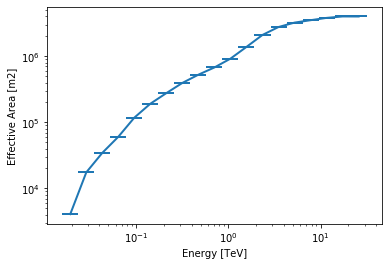

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

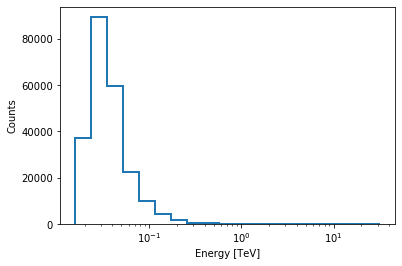

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Spatial Component
spatial_model = PointSpatialModel(
    lon_0="0 deg", lat_0="0 deg", frame="icrs"
)

In [10]:
# DM Flux
spectral_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [11]:
#from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#spectral_model = AbsorbedSpectralModel(spectral_model, absorption_model, redshift)

In [12]:
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
models = SkyModels([sky_model])

In [13]:
dataset = DMDatasetOnOff(
    aeff=aeff,
    models=models,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)

In [14]:
nuisance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    sigmatau=0.01,
    # width=5 # default value / optional param 
)
dataset.nuisance = nuisance

## The SigmaVEstimator

**Enable inspection**

In [15]:
import logging
logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels, background_model=bkg)

**Run estimator and fetch results**

In [17]:
%%time
# stat_profile_opts=dict(bounds=(-25, 100), nvalues=125)   # optional param
# stat_profile_opts = dict(bounds=5, nvalues=50)           # default values
# if nuisance = True the process takes the nuisance parameters into account
result = estimator.run(runs=3, nuisance=True)

INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.9529 	| LZero: 113.292 	| LMin:  112.339
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 1484.5478 	| LMax: 1596.887 	| LMin:  112.339
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 27.458 	| SvBest: 27.458 	| SvUL: 144.555
DEBUG:gammapy.astro.darkmatter.utils:JBest: 3.339994712012402e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:4.33665517280246e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.2297 	| LZero: 113.292 	| LMin:  113.063
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 540.7406 	| LMax: 653.803 	| LMin:  113.063
DEBUG:gammapy.

DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 156.2473 	| LMax: 266.175 	| LMin:  109.928
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 60.657 	| SvBest: 60.657 	| SvUL: 154.881
DEBUG:gammapy.astro.darkmatter.utils:JBest: 1.848718062223274e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:4.646427100983967e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.5683 	| LZero: 113.263 	| LMin:  112.695
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 1.3324 	| LMax: 114.027 	| LMin:  112.695
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.2950 	| LZero: 113.121 	| LMin:  112.826
DEBUG:gammapy.ast

INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 1.8774 	| LZero: 113.125 	| LMin:  111.248
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 456.4095 	| LMax: 569.535 	| LMin:  113.125
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -6.072 	| SvBest: 0.000 	| SvUL: 6.906
DEBUG:gammapy.astro.darkmatter.utils:JBest: 3.150757969472396e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.0718844463177904e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 2.4140 	| LZero: 112.128 	| LMin:  109.714
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 175.8493 	| LMax: 287.978 	| LMin:  112.128
DEBUG:gam

DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 670.5797 	| LMax: 775.987 	| LMin:  105.408
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 12.118 	| SvBest: 12.118 	| SvUL: 63.778
DEBUG:gammapy.astro.darkmatter.utils:JBest: 4.3089165190058074e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.913328607289713e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 2
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.9302 	| LZero: 107.693 	| LMin:  106.763
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 11.1023 	| LMax: 117.865 	| LMin:  106.763
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 8.114 	| SvBest: 8.114 	| SvUL: 63.776
DEBUG:gammapy.astro.darkmatter.utils:JBest: 5.043653367731456e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.9132767479380715e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:ga

INFO:gammapy.astro.darkmatter.utils:Sigma v:1.8614638570598534e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 2
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 1.6616 	| LZero: 107.745 	| LMin:  106.083
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 12.9951 	| LMax: 119.079 	| LMin:  106.083
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 8.561 	| SvBest: 8.561 	| SvUL: 58.165
DEBUG:gammapy.astro.darkmatter.utils:JBest: 5.0818514142035526e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.74494195526097e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 2
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.3965 	| LZero: 107.812 	| LMin:  107.416
DEBUG:gammapy.astro.darkmatter.utils:

CPU times: user 2min 31s, sys: 3.23 s, total: 2min 34s
Wall time: 2min 44s


**Display results for channel b and run 0**

In [19]:
cols = ["mass", "sigma_v", "sv_ul", "sv_best", "j_best"]
result["runs"]["b"][1][cols]

mass,sigma_v,sv_ul,sv_best,j_best
GeV,cm3 / s,,,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,3.6332172772082464e-24,121.10724257360822,23.44337255440503,2.182118756679005e+19
200.0,3.045707399129047e-24,101.52357997096823,16.72529308904033,4.627148629870115e+19
500.0,2.8312460783863315e-24,94.37486927954438,35.780283568143204,2.6812865690848883e+19
1000.0,2.2117595201214014e-24,73.72531733738005,20.10889056686785,3.550387652846345e+19
5000.0,1.4788315625799891e-24,49.29438541933297,5.478306116006758,5.107631020350189e+19
10000.0,1.0936944895976948e-24,36.456482986589826,0.0,4.965226394295332e+19
50000.0,9.750493183740094e-25,32.50164394580031,0.0,3.658351519213907e+19


**Plot likelihood profile for a specific fit**

In [20]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["Z"][0]["statprofile"][idx][0][0]

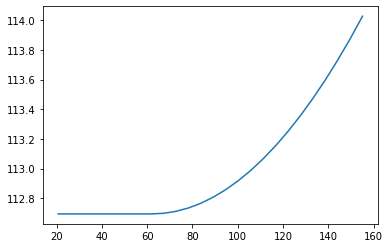

In [21]:
plt.plot(profile["values"], profile["stat"]);

## Obtained results

In [22]:
result["mean"]["b"]

mass,sigma_v,sigma_v_std,jfactor,jfactor_std
GeV,cm3 / s,cm3 / s,GeV2 / cm5,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,2.986368412174928e-24,6.468488650333186e-25,3.3200869590691566e+19,9.211274100969498e+18
200.0,2.3673713239675038e-24,6.783360751615429e-25,4.410821106235591e+19,6.763687088798327e+18
500.0,2.3600174789036104e-24,4.712285994827209e-25,4.1947940308473094e+19,1.070870459539588e+19
1000.0,2.0246318760813534e-24,1.87127644040048e-25,2.9021767587316797e+19,8.471263935283829e+18
5000.0,1.696080084934851e-24,2.172485223548619e-25,4.609810368216922e+19,3.545620189720516e+18
10000.0,1.5034856187678831e-24,4.0979112917018834e-25,4.69887212984837e+19,4.3332255053000023e+18
50000.0,1.4803828359500667e-24,5.053335175760573e-25,4.398311089847673e+19,5.835175920561007e+18


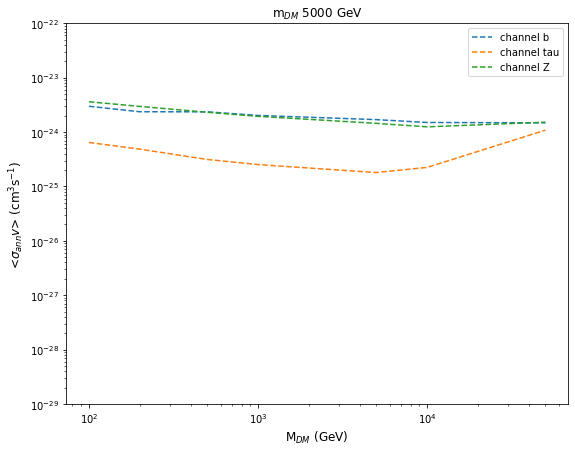

In [23]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();